In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Important part is converting the json to mask image

In [2]:
import json
json_path = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/_annotations.coco.json'

with open(json_path,'r') as file:
    data = json.load(file)

for img in data['images'][:10]:
    print(img['file_name'])

1997_jpg.rf.57e306420710246d04c0d5c26e6496c6.jpg
2422_jpg.rf.59a35b6d8d2eed150af8535cf09bbde5.jpg
1630_jpg.rf.5afc6e25d7987503a11bcb0791b60b53.jpg
1330_jpg.rf.5b23bf18a29b0f50e376b19a5a84f823.jpg
2768_jpg.rf.5b87c0023909e0789a33185a3aab92e9.jpg
2647_jpg.rf.5ba404374f2d670f04a2d1367c77c039.jpg
1511_jpg.rf.5c02bb67a267960293c9e8393c2d9380.jpg
1018_jpg.rf.5c6fcb4480745ff7c60c7305781913ab.jpg
1694_jpg.rf.5c8d647ce366cbd41426af5217863bd4.jpg
2824_jpg.rf.5ca7452639b345dfd0206a58531b6910.jpg


In [3]:
data['categories']

[{'id': 0, 'name': 'Tumor', 'supercategory': 'none'},
 {'id': 1, 'name': '0', 'supercategory': 'Tumor'},
 {'id': 2, 'name': '1', 'supercategory': 'Tumor'}]

# Data Visualization

In [4]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

In [5]:
def draw_mask(img_names,data):
    fig,ax = plt.subplots(2,2,figsize =(15,15))
    
    for i,img_name in enumerate(img_names):
        img = cv2.imread(img_name)
        img_filename = os.path.basename(img_name)
        img_id = [item for item in data['images'] if item['file_name'] == img_filename][0]['id']
        img_mask = [mask for mask in data['annotations'] if mask['image_id']==img_id]
        point_list = img_mask[0]['segmentation']
        points = np.array(point_list,np.int32)
      
        points = points.reshape((-1,1,2))
       
        
        cv2.polylines(img,[points],True,(0,0,255),3)
        
        ax[i//2, i%2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[i//2, i%2].axis('off')
    plt.show()

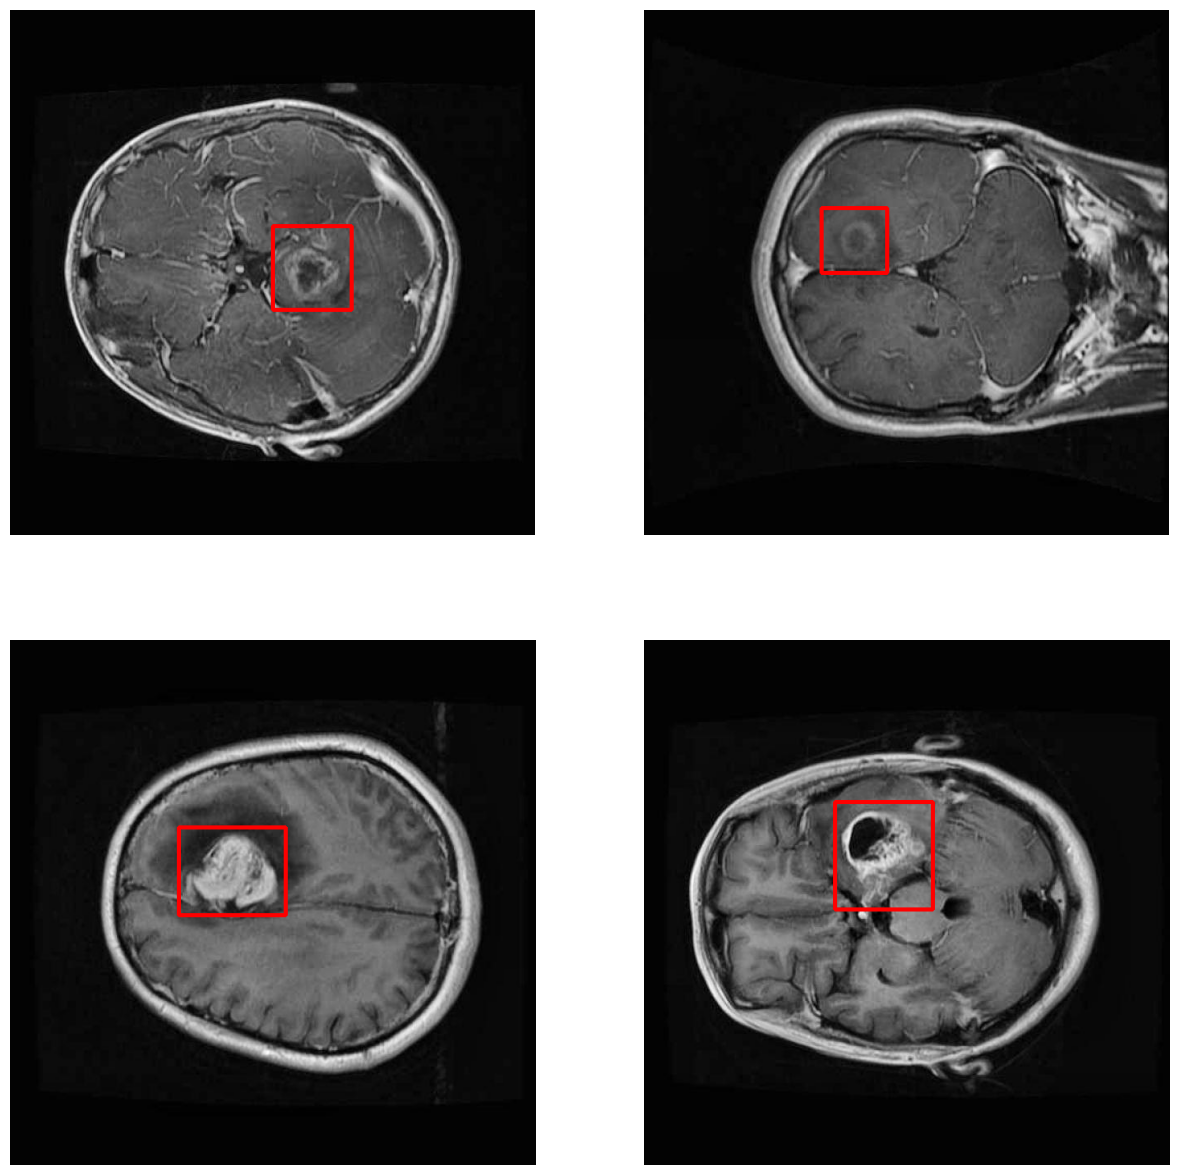

In [6]:
with open(json_path,'r') as file:
    data = json.load(file)

img_dir = "/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid"
all_img_files = [os.path.join(img_dir,img['file_name']) for img in data['images']]
random_file = random.sample(all_img_files,4)
draw_mask(random_file,data)

# Convert to mask

In [7]:
import json
import numpy as np
import skimage.draw
import tifffile
import os
import shutil
import matplotlib.pyplot as plt

def create_mask(image_info,annotations,output_folder,max_print=3):
    mask_np =np.zeros((image_info['height'],image_info['width']),dtype=np.uint8)
    obj_number =1
    printed_masks =0;
    
    for ann in annotations:
        if image_info['id'] == ann['image_id']:
            for seg_idx ,seg in enumerate(ann['segmentation']):
                rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
                seg_mask = np.zeros_like(mask_np,dtype=np.uint8)
                seg_mask[rr,cc]=255
                mask_path = os.path.join(output_folder, f"{image_info['file_name'].replace('.jpg', '')}_seg_{seg_idx}.tif")
                tifffile.imwrite(mask_path, seg_mask)
                printed_masks += 1
                if printed_masks >= max_print:
                    return  # Exit the function if maximum number of masks to print is reached
        
    

In [8]:
def main(json_file,mask_output_folder,image_output_folder,original_image_dir):
    with open(json_file, 'r') as f:
        data = json.load(f)
        
    images = data['images']
    annotations = data['annotations']
     # Ensure the output directories exist
    if not os.path.exists(mask_output_folder):
        os.makedirs(mask_output_folder)
    if not os.path.exists(image_output_folder):
        os.makedirs(image_output_folder)
    for img in images:
        # Create the masks
        create_mask(img, annotations, mask_output_folder)
        # Copy original images to the specified folder
        original_image_path = os.path.join(original_image_dir, img['file_name'])
        new_image_path = os.path.join(image_output_folder, os.path.basename(original_image_path))
        
        ## learn how to op
        shutil.copy2(original_image_path, new_image_path)

In [9]:
original_image_dir = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test'  # Where your original images are stored
json_file = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test/_annotations.coco.json'
mask_output_folder = 'test2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
image_output_folder = 'test2/images'  # 
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

original_image_dir = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train'  # Where your original images are stored
json_file = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train/_annotations.coco.json'
mask_output_folder = 'train2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
image_output_folder = 'train2/images'  # 
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

original_image_dir = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid'  # Where your original images are stored
json_file = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/_annotations.coco.json'
mask_output_folder = 'valid2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
image_output_folder = 'valid2/images'  # 
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

# Delete the image without the mask

In [10]:
def compare_folders(folder1,folder2):
    folder1_items = os.listdir(folder1)
    folder2_items = os.listdir(folder2)
    
    for item1 in folder1_items:
        f =False
        
        for j in folder2_items:
            if item1[:4] == j[:4]:
                f=True
                break
        if not f:
            print(f"Corresponding item for {item1} not found.")
            item1_path = os.path.join(folder1, item1)
            os.remove(item1_path)
            print(f"Deleted {item1}")
            
    for item2 in folder2_items:
        f =False
        
        for j in folder1_items:
            if item2[:4] == j[:4]:
                f=True
                break
        if not f:
            print(f"Corresponding item for {item2} not found.")
            item2_path = os.path.join(folder2, item2)
            os.remove(item1_path)
            print(f"Deleted {item1}")

folder1_path = "/kaggle/working/train2/images"
folder2_path = "/kaggle/working/train2/masks"
compare_folders(folder1_path, folder2_path)

Corresponding item for 2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg not found.
Deleted 2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg


# Dataset

In [11]:
class MatchDataset:
    def __init__(self,root_dir):
        self.root = root_dir
        self.image_f = os.path.join(root_dir,'images')
        self.mask_f = os.path.join(root_dir,'masks')
        self.images = sorted(os.listdir(self.image_f))
        self.masks = sorted(os.listdir(self.mask_f))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,index):
        img_name = self.images[index]
        mask_name = self.masks[index]
        img_path = os.path.join(self.image_f,img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        mask_path = os.path.join(self.mask_f,mask_name)
        mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        
        return img,mask

dataset = MatchDataset("/kaggle/working/test2")
img,mask = dataset[0]
img.shape,mask.shape
        



((640, 640, 3), (640, 640))

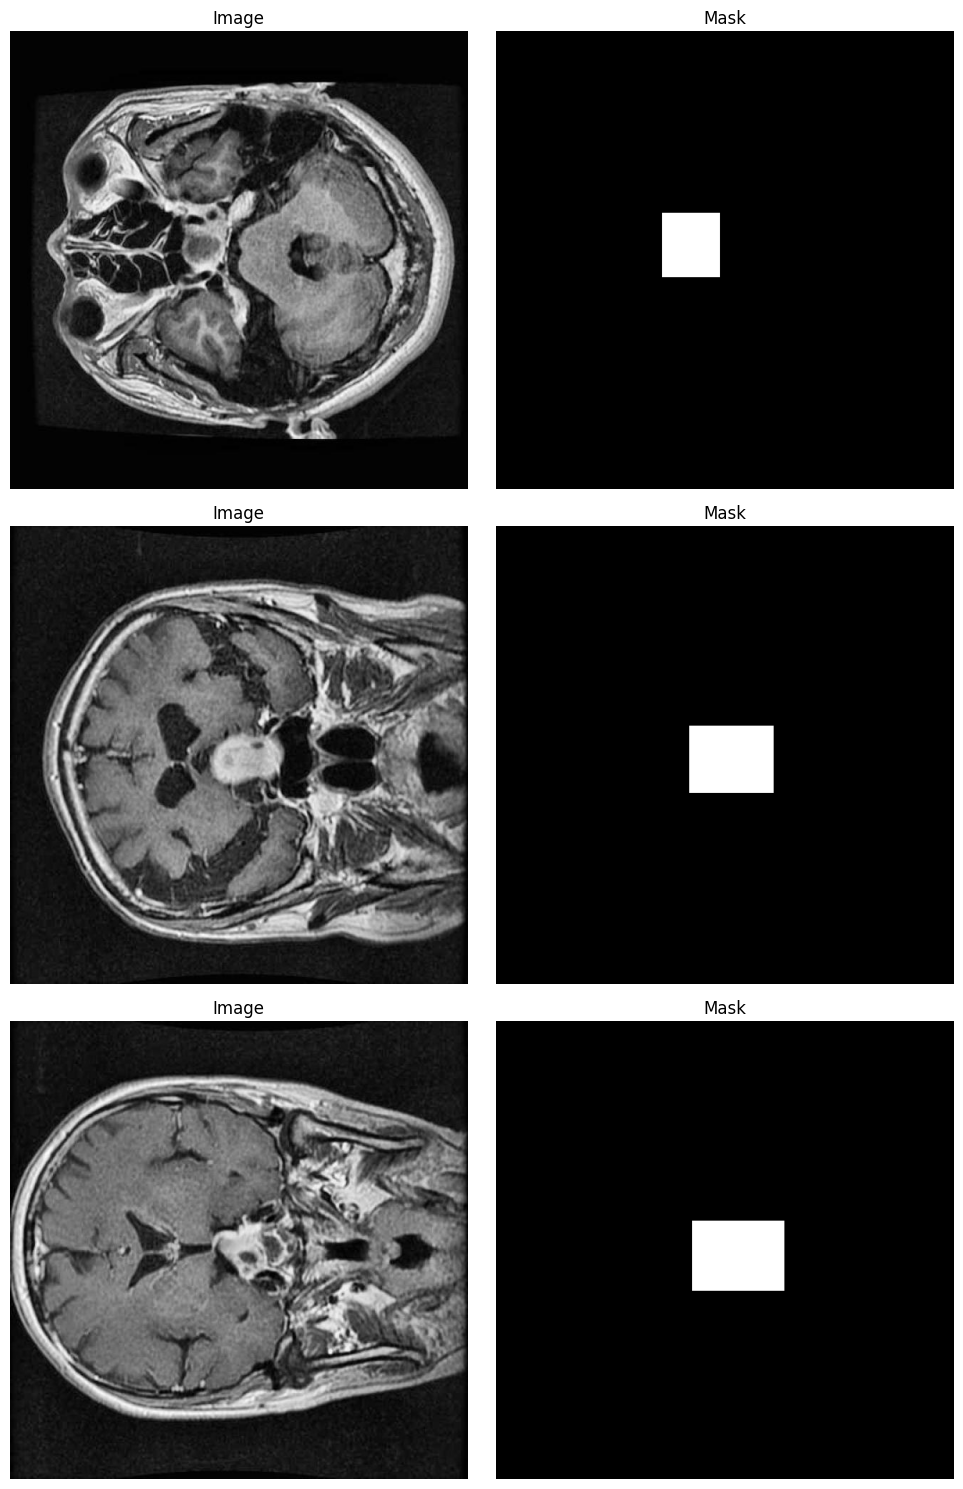

In [12]:
fig,axs = plt.subplots(3,2,figsize=(10,15))
for i in range(3):  # Plot the first three samples
    image, mask = dataset[i]
    axs[i, 0].imshow(image)
    axs[i, 0].set_title('Image')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].set_title('Mask')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Torch Dataset


In [13]:
import os
import torch.nn as nn
from  torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

class BrainDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, "images")
        self.mask_folder = os.path.join(root_dir, "masks")
        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))
        self.transform = transform
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self,idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("RGB")
        image_gray = image.convert("L")  # Convert to grayscale
        mask_name = self.mask_files[idx]
        mask_path = os.path.join(self.mask_folder, mask_name)
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            # Apply transformations
            image_gray = self.transform(image_gray)
            mask = self.transform(mask)
        return image_gray,mask



In [14]:
train_path = "/kaggle/working/train2" 
valid_path = "/kaggle/working/valid2"
test_path = "/kaggle/working/test2"
image_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale images
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

In [15]:
train_dataset = BrainDataset(train_path, transform=image_transform)
valid_dataset = BrainDataset(valid_path, transform=image_transform)
test_dataset = BrainDataset(test_path, transform=image_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model

In [16]:
from __future__ import print_function, division
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch


class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x


class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class U_Net(nn.Module):
    """
    UNet - Basic Implementation
    Paper : https://arxiv.org/abs/1505.04597
    """
    def __init__(self, in_ch=3, out_ch=1):
        super(U_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
        
        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(in_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)

       # self.active = torch.nn.Sigmoid()

    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)
        d5 = torch.cat((e4, d5), dim=1)

        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        #d1 = self.active(out)

        return out


class Recurrent_block(nn.Module):
    """
    Recurrent Block for R2Unet_CNN
    """
    def __init__(self, out_ch, t=2):
        super(Recurrent_block, self).__init__()

        self.t = t
        self.out_ch = out_ch
        self.conv = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        for i in range(self.t):
            if i == 0:
                x = self.conv(x)
            out = self.conv(x + x)
        return out


class RRCNN_block(nn.Module):
    """
    Recurrent Residual Convolutional Neural Network Block
    """
    def __init__(self, in_ch, out_ch, t=2):
        super(RRCNN_block, self).__init__()

        self.RCNN = nn.Sequential(
            Recurrent_block(out_ch, t=t),
            Recurrent_block(out_ch, t=t)
        )
        self.Conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x1 = self.Conv(x)
        x2 = self.RCNN(x1)
        out = x1 + x2
        return out


class R2U_Net(nn.Module):
    """
    R2U-Unet implementation
    Paper: https://arxiv.org/abs/1802.06955
    """
    def __init__(self, img_ch=3, output_ch=1, t=2):
        super(R2U_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(img_ch, filters[0], t=t)

        self.RRCNN2 = RRCNN_block(filters[0], filters[1], t=t)

        self.RRCNN3 = RRCNN_block(filters[1], filters[2], t=t)

        self.RRCNN4 = RRCNN_block(filters[2], filters[3], t=t)

        self.RRCNN5 = RRCNN_block(filters[3], filters[4], t=t)

        self.Up5 = up_conv(filters[4], filters[3])
        self.Up_RRCNN5 = RRCNN_block(filters[4], filters[3], t=t)

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_RRCNN4 = RRCNN_block(filters[3], filters[2], t=t)

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_RRCNN3 = RRCNN_block(filters[2], filters[1], t=t)

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_RRCNN2 = RRCNN_block(filters[1], filters[0], t=t)

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)

       # self.active = torch.nn.Sigmoid()


    def forward(self, x):

        e1 = self.RRCNN1(x)

        e2 = self.Maxpool(e1)
        e2 = self.RRCNN2(e2)

        e3 = self.Maxpool1(e2)
        e3 = self.RRCNN3(e3)

        e4 = self.Maxpool2(e3)
        e4 = self.RRCNN4(e4)

        e5 = self.Maxpool3(e4)
        e5 = self.RRCNN5(e5)

        d5 = self.Up5(e5)
        d5 = torch.cat((e4, d5), dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_RRCNN2(d2)

        out = self.Conv(d2)

      # out = self.active(out)

        return out


class Attention_block(nn.Module):
    """
    Attention Block
    """

    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out


class AttU_Net(nn.Module):
    """
    Attention Unet implementation
    Paper: https://arxiv.org/abs/1804.03999
    """
    def __init__(self, img_ch=3, output_ch=1):
        super(AttU_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)

        #self.active = torch.nn.Sigmoid()


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        #print(x5.shape)
        d5 = self.Up5(e5)
        #print(d5.shape)
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

      #  out = self.active(out)

        return out


class R2AttU_Net(nn.Module):
    """
    Residual Recuurent Block with attention Unet
    Implementation : https://github.com/LeeJunHyun/Image_Segmentation
    """
    def __init__(self, in_ch=3, out_ch=1, t=2):
        super(R2AttU_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.RRCNN1 = RRCNN_block(in_ch, filters[0], t=t)
        self.RRCNN2 = RRCNN_block(filters[0], filters[1], t=t)
        self.RRCNN3 = RRCNN_block(filters[1], filters[2], t=t)
        self.RRCNN4 = RRCNN_block(filters[2], filters[3], t=t)
        self.RRCNN5 = RRCNN_block(filters[3], filters[4], t=t)

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_RRCNN5 = RRCNN_block(filters[4], filters[3], t=t)

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_RRCNN4 = RRCNN_block(filters[3], filters[2], t=t)

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_RRCNN3 = RRCNN_block(filters[2], filters[1], t=t)

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_RRCNN2 = RRCNN_block(filters[1], filters[0], t=t)

        self.Conv = nn.Conv2d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)

       # self.active = torch.nn.Sigmoid()


    def forward(self, x):

        e1 = self.RRCNN1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.RRCNN2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.RRCNN3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.RRCNN4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.RRCNN5(e5)

        d5 = self.Up5(e5)
        e4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((e4, d5), dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        e3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        e2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        e1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_RRCNN2(d2)

        out = self.Conv(d2)

      #  out = self.active(out)

        return out

#For nested 3 channels are required

class conv_block_nested(nn.Module):
    
    def __init__(self, in_ch, mid_ch, out_ch):
        super(conv_block_nested, self).__init__()
        self.activation = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)

        return output
    
#Nested Unet

class NestedUNet(nn.Module):
    """
    Implementation of this paper:
    https://arxiv.org/pdf/1807.10165.pdf
    """
    def __init__(self, in_ch=3, out_ch=1):
        super(NestedUNet, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])
        self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], filters[2])
        self.conv3_1 = conv_block_nested(filters[3] + filters[4], filters[3], filters[3])

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], filters[1])
        self.conv2_2 = conv_block_nested(filters[2]*2 + filters[3], filters[2], filters[2])

        self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1]*3 + filters[2], filters[1], filters[1])

        self.conv0_4 = conv_block_nested(filters[0]*4 + filters[1], filters[0], filters[0])

        self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)


    def forward(self, x):
        
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.Up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)], 1))

        output = self.final(x0_4)
        return output

#Dictioary Unet
#if required for getting the filters and model parameters for each step 

class ConvolutionBlock(nn.Module):
    """Convolution block"""

    def __init__(self, in_filters, out_filters, kernel_size=3, batchnorm=True, last_active=F.relu):
        super(ConvolutionBlock, self).__init__()

        self.bn = batchnorm
        self.last_active = last_active
        self.c1 = nn.Conv2d(in_filters, out_filters, kernel_size, padding=1)
        self.b1 = nn.BatchNorm2d(out_filters)
        self.c2 = nn.Conv2d(out_filters, out_filters, kernel_size, padding=1)
        self.b2 = nn.BatchNorm2d(out_filters)

    def forward(self, x):
        x = self.c1(x)
        if self.bn:
            x = self.b1(x)
        x = F.relu(x)
        x = self.c2(x)
        if self.bn:
            x = self.b2(x)
        x = self.last_active(x)
        return x


class ContractiveBlock(nn.Module):
    """Deconvuling Block"""

    def __init__(self, in_filters, out_filters, conv_kern=3, pool_kern=2, dropout=0.5, batchnorm=True):
        super(ContractiveBlock, self).__init__()
        self.c1 = ConvolutionBlock(in_filters=in_filters, out_filters=out_filters, kernel_size=conv_kern,
                                   batchnorm=batchnorm)
        self.p1 = nn.MaxPool2d(kernel_size=pool_kern, ceil_mode=True)
        self.d1 = nn.Dropout2d(dropout)

    def forward(self, x):
        c = self.c1(x)
        return c, self.d1(self.p1(c))


class ExpansiveBlock(nn.Module):
    """Upconvole Block"""

    def __init__(self, in_filters1, in_filters2, out_filters, tr_kern=3, conv_kern=3, stride=2, dropout=0.5):
        super(ExpansiveBlock, self).__init__()
        self.t1 = nn.ConvTranspose2d(in_filters1, out_filters, tr_kern, stride=2, padding=1, output_padding=1)
        self.d1 = nn.Dropout(dropout)
        self.c1 = ConvolutionBlock(out_filters + in_filters2, out_filters, conv_kern)

    def forward(self, x, contractive_x):
        x_ups = self.t1(x)
        x_concat = torch.cat([x_ups, contractive_x], 1)
        x_fin = self.c1(self.d1(x_concat))
        return x_fin


class Unet_dict(nn.Module):
    """Unet which operates with filters dictionary values"""

    def __init__(self, n_labels, n_filters=32, p_dropout=0.5, batchnorm=True):
        super(Unet_dict, self).__init__()
        filters_dict = {}
        filt_pair = [3, n_filters]

        for i in range(4):
            self.add_module('contractive_' + str(i), ContractiveBlock(filt_pair[0], filt_pair[1], batchnorm=batchnorm))
            filters_dict['contractive_' + str(i)] = (filt_pair[0], filt_pair[1])
            filt_pair[0] = filt_pair[1]
            filt_pair[1] = filt_pair[1] * 2

        self.bottleneck = ConvolutionBlock(filt_pair[0], filt_pair[1], batchnorm=batchnorm)
        filters_dict['bottleneck'] = (filt_pair[0], filt_pair[1])

        for i in reversed(range(4)):
            self.add_module('expansive_' + str(i),
                            ExpansiveBlock(filt_pair[1], filters_dict['contractive_' + str(i)][1], filt_pair[0]))
            filters_dict['expansive_' + str(i)] = (filt_pair[1], filt_pair[0])
            filt_pair[1] = filt_pair[0]
            filt_pair[0] = filt_pair[0] // 2

        self.output = nn.Conv2d(filt_pair[1], n_labels, kernel_size=1)
        filters_dict['output'] = (filt_pair[1], n_labels)
        self.filters_dict = filters_dict

    # final_forward
    def forward(self, x):
        c00, c0 = self.contractive_0(x)
        c11, c1 = self.contractive_1(c0)
        c22, c2 = self.contractive_2(c1)
        c33, c3 = self.contractive_3(c2)
        bottle = self.bottleneck(c3)
        u3 = F.relu(self.expansive_3(bottle, c33))
        u2 = F.relu(self.expansive_2(u3, c22))
        u1 = F.relu(self.expansive_1(u2, c11))
        u0 = F.relu(self.expansive_0(u1, c00))
        return F.softmax(self.output(u0), dim=1)




# Loss

In [17]:
import torch.nn.functional as F
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss,self).__init__()
        
    
    def forward(self,inputs,target):
        inputs = torch.sigmoid(inputs)
        smooth = 1.0
        inputs = inputs.reshape(-1)
        tar = target.reshape(-1)
        intersection = (inputs*tar).sum()
        
        dic_loss = 1-((2.0*intersection+smooth)/(inputs.sum()+tar.sum()+smooth))
        
        return dic_loss
class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss,self).__init__()
    
    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE
        
    

In [18]:
x, y = next(iter(train_loader))
x.shape , y.shape , type(x) , type(y)

(torch.Size([16, 1, 224, 224]),
 torch.Size([16, 1, 224, 224]),
 torch.Tensor,
 torch.Tensor)

# Hyperparameter

In [19]:
path_save = "files/"
if not os.path.exists(path_save):
    os.makedirs(path_save)

In [20]:
checkpoints_path = "files/checkpoints.pth"
num_epochs = 50
lr=1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = DiceBCELoss()

# Attention Unet

In [21]:
model = AttU_Net(1,1)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [22]:
from tqdm import tqdm
def train(model,optimizer,loss_fn,loader,device):
    epoch_loss =0.0
    model.train()
    
    for x,y in tqdm(loader):
        x = x.to(device,dtype = torch.float32)
        y = y.to(device, dtype = torch.float32)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        epoch_loss +=loss.item()
    
    return epoch_loss/len(loader)
        
    

In [23]:
def valid(model,loader,loss_fn,device):
    epoch_loss = 0.0
    model.eval()
    
    for x,y in loader:
        x = x.to(device,dtype = torch.float32)
        y = y.to(device, dtype = torch.float32)
        pred = model(x)
        loss = loss_fn(pred,y)
        epoch_loss +=loss.item()
    return epoch_loss/len(loader)

Epoch 50/50, Train Loss: 0.0684
Cross Loss: 0.4478


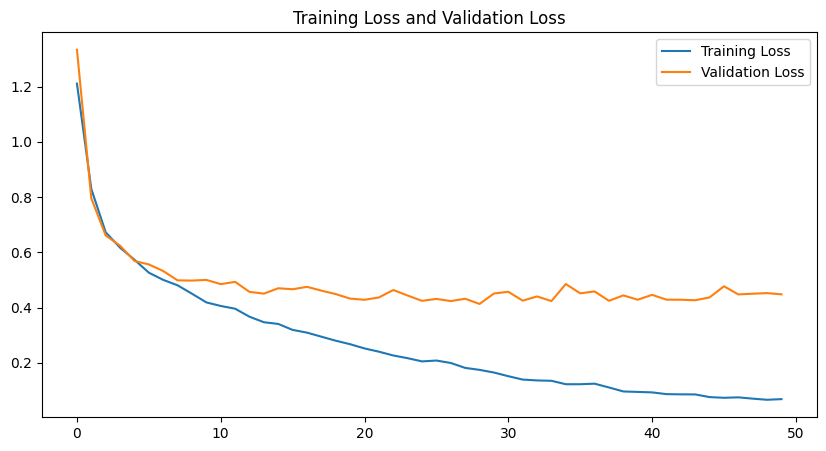

In [24]:
from IPython.display import clear_output
best_val_loss = float('inf')
train_losses = []
cross_losses = []
for epoch in range(num_epochs):
    train_loss = train(model,optimizer,loss_fn,train_loader,device)
    val_loss = valid(model,valid_loader,loss_fn,device)
    train_losses.append(train_loss)
    cross_losses.append(val_loss)
    
    clear_output(wait=True)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')
    print(f'Cross Loss: {val_loss:.4f}')
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(cross_losses, label='Validation Loss')
    plt.title('Training Loss and Validation Loss')
    plt.legend()
    plt.show(block=False)
    
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoints_path)

## Predict

In [25]:
def visualize_input_output_target(input_image, output_image, target_image):
    # Move tensors to CPU memory if they are on CUDA devices
    input_image = input_image.cpu()
    output_image = output_image.cpu()
    target_image = target_image.cpu()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot input image
    axes[0].imshow(input_image.squeeze().numpy(), cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    # Plot output image (predicted binary mask)
    axes[1].imshow(output_image.squeeze().numpy(), cmap='gray')
    axes[1].set_title('Output Image (Predicted)')
    axes[1].axis('off')

    # Plot target image (ground truth binary mask)
    axes[2].imshow(target_image.squeeze().numpy(), cmap='gray')
    axes[2].set_title('Target Image (Ground Truth)')
    axes[2].axis('off')

    plt.show()
    fig.savefig("output.png")


In [26]:
model = AttU_Net(1,1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load(checkpoints_path,map_location = device))
model.eval()

AttU_Net(
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affi

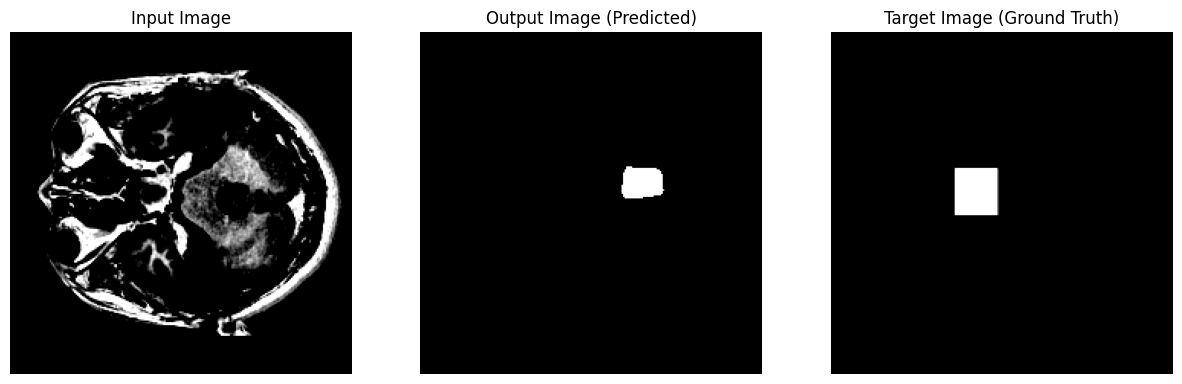

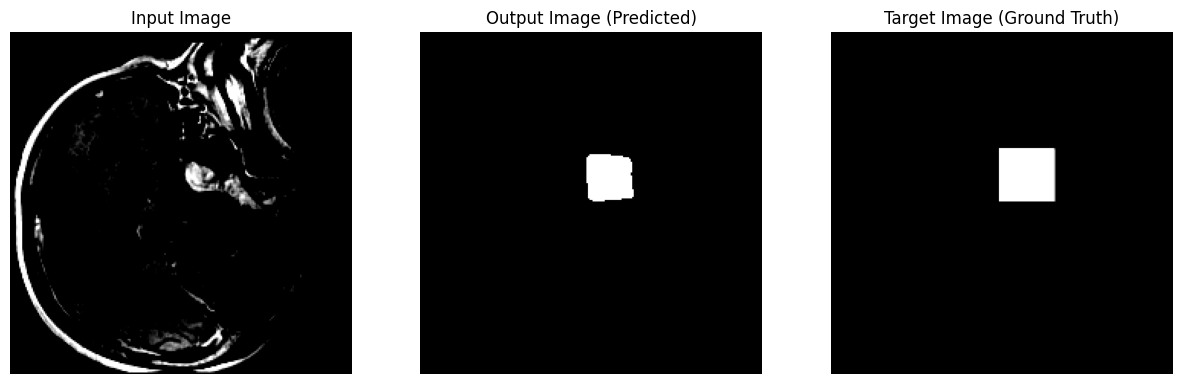

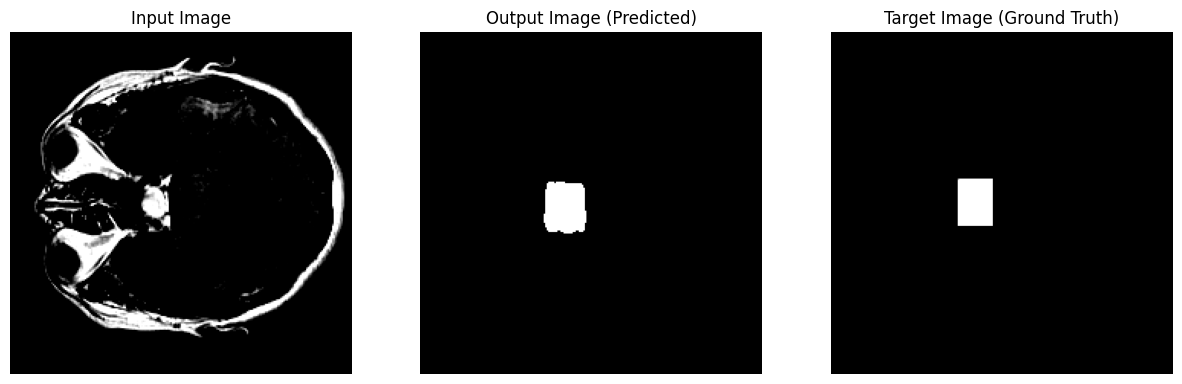

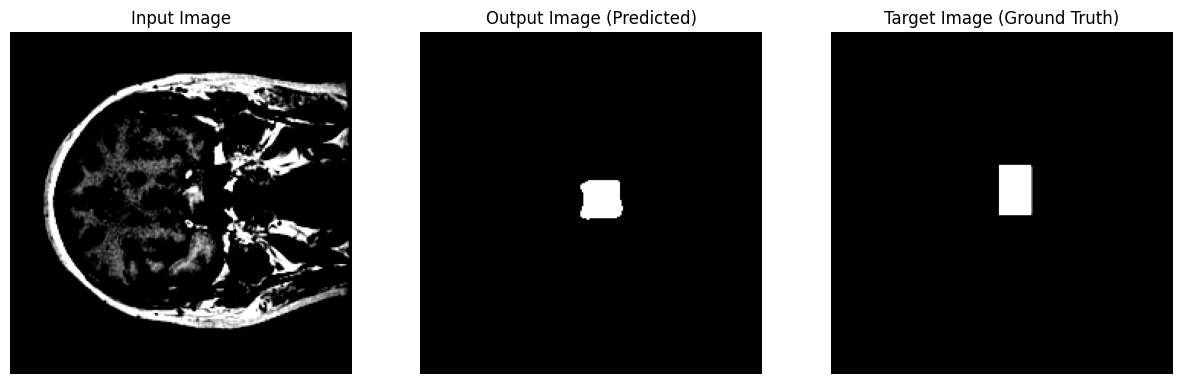

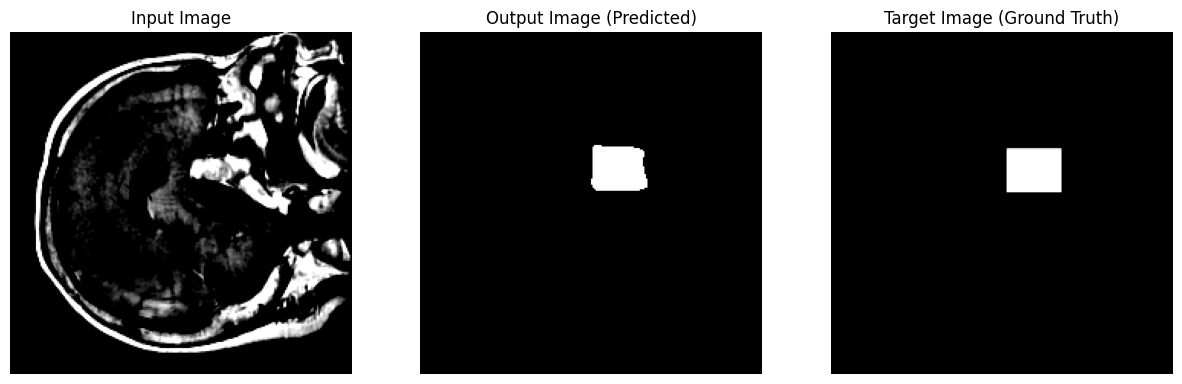

In [27]:
idx =0
for x,y in test_loader:
    x  =x.to(device,dtype = torch.float32)
    y = y.to(device,dtype = torch.float32)
    
    pred = model(x)
    y_pred = (pred>0.5).float()
    if idx <5:
        visualize_input_output_target(x[0],y_pred[0],y[0])
    idx +=1